In [1]:
import sys
import os
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# add GADES to the path
GADES_path = os.path.abspath(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "GADES"))
sys.path.append(GADES_path)
from utils import muller_brown_potential_plot as get_U_plot
from utils import muller_brown_force_base as get_F
from utils import muller_brown_hess_base as get_H
from bofill import get_bofill_H

In [2]:
# Create a grid of x and y values
x0 = np.linspace(-3.5, 2.0, 30)
x1 = np.linspace(-1.5, 3.5, 30)
X0, X1 = np.meshgrid(x0, x1)
Z = get_U_plot(x0, x1)

In [3]:
def get_gad_force(h, forces_u):
    w, v = jnp.linalg.eigh(h)
    n = v[:,0]
    n = n/jnp.sqrt(jnp.dot(n,n))
    forces_b = -jnp.dot(forces_u,n)*n
    return forces_b

def muller_brown_gad_force_base(positions, forces_u, kappa=0.9):
    global queue_fb
    """ GADES forces for the Muller-Brown potential at `position` calculated using AD. Calculates the total forces, then finds the most-negative eigenvalue and the corresponding eigenvector of the Hessian and returns negative `kappa` times the force projected in the eigenvector direction as the biasing force.

    Args:
        position (jax.ndarray): (2, ) position
        kappa (float): GAD intensity parameter. Determines how much of the GAD force is used for biasing. `kappa=1` is 100% and `kappa=0` is none.

    Returns:
        jax.ndarray: (2, ) GAD bias forces vector
    """

    # biased forces (softened by kappa)
    h = get_H(positions)
    
    forces_b = get_gad_force(h, forces_u)
    
    # update the queues
    queue_fb = jnp.roll(queue_fb, -1, axis=0)
    queue_fb = queue_fb.at[-1].set(forces_b)
    
    # Calculate a weighted average of the last 10 bias forces based on their magnitude.
    # get the magnitude of the forces
    avg_weights = jnp.linalg.norm(queue_fb, axis=1)
    # get the average direction of the forces weighted by their magnitude
    fb_dirs = jnp.average(queue_fb, axis=0, weights=avg_weights)
    # normalize the average direction vector
    fb_dirs /= jnp.linalg.norm(fb_dirs)
    # move in the direction of the average vector with magnitude of the current bias vector
    forces_b_avg = fb_dirs*jnp.linalg.norm(forces_b)
    # dampen the bias with kappa
    forces_b_avg *= kappa
    
    return forces_b_avg

def muller_brown_gad_force_bofill(positions, positions_old, forces_u, forces_u_old, step, kappa=0.9):
    global last_h, queue_fb
    """ GADES forces for the Muller-Brown potential at `position` calculated using AD. Calculates the total forces, then finds the most-negative eigenvalue and the corresponding eigenvector of the Hessian and returns negative `kappa` times the force projected in the eigenvector direction as the biasing force.

    Args:
        position (jax.ndarray): (2, ) position
        kappa (float): GAD intensity parameter. Determines how much of the GAD force is used for biasing. `kappa=1` is 100% and `kappa=0` is none.

    Returns:
        jax.ndarray: (2, ) GAD bias forces vector
    """

    # unbiased forces

    if (step % 100) == 0:
        # biased forces (softened by kappa)
        h = get_H(positions)
    else:
        h = get_bofill_H(positions, positions_old, -forces_u, -forces_u_old, last_h)
    
    forces_b = get_gad_force(h, forces_u)
    
    # update the queues
    last_h = h
    queue_fb = jnp.roll(queue_fb, -1, axis=0)
    queue_fb = queue_fb.at[-1].set(forces_b)
    
    # Calculate a weighted average of the last 10 bias forces based on their magnitude.
    # get the magnitude of the forces
    avg_weights = jnp.linalg.norm(queue_fb, axis=1)
    # get the average direction of the forces weighted by their magnitude
    fb_dirs = jnp.average(queue_fb, axis=0, weights=avg_weights)
    # normalize the average direction vector
    fb_dirs /= jnp.linalg.norm(fb_dirs)
    # move in the direction of the average vector with magnitude of the current bias vector
    forces_b_avg = fb_dirs*jnp.linalg.norm(forces_b)
    # dampen the bias with kappa
    forces_b_avg *= kappa
    
    return forces_b_avg

def baoab_langevin_integrator(positions, velocities, forces_u, forces_b, mass, gamma, dt, kBT, force_function_u, force_function_b, step, bofill=False):
    """
    BAOAB Langevin integrator based on Leimkuhler and Matthews (2013).
    https://dx.doi.org/10.1093/amrx/abs010

    Parameters:
        positions (jax.ndarray): Initial positions (shape: [D, ], where D is dimensionality).
        velocities (jax.ndarray): Initial velocities (shape: [D, ]).
        forces_u (jax.ndarray): Initial unbiased forces (shape: [D, ]).
        forces_b (jax.ndarray): Initial biased forces (shape: [D, ]).
        mass (float): Mass of the particles (scalar).
        gamma (float): Friction coefficient. (scalar).
        dt (float): Time step. (scalar).
        n_steps (int): Number of simulation steps. (scalar).
        kBT (float): Thermal energy (\(k_B T\)). (scalar).
        force_function_u (callable): Function to compute unbiased forces given positions (returns forces of shape [D, ]).
        force_function_b (callable): Function to compute biased forces given positions (returns forces of shape [D, ]).

    Returns:
        positions (jax.ndarray): New positions (shape: [D, ]).
        velocities (jax.ndarray): New velocities (shape: [D, ]).
        forces_u (jax.ndarray): Unbiased forces at new position (shape: [D, ]).
        forces_b (jax.ndarray): Biased forces at new position (shape: [D, ]).
    """
    dim = positions.shape[0]

    # Precompute constants
    c1 = jnp.exp(-gamma * dt)
    c3 = jnp.sqrt(kBT * (1 - c1**2))
    inv_mass = jnp.reciprocal(mass)
    inv_mass_sqrt = jnp.reciprocal(jnp.sqrt(mass))
    positions_old = positions.copy()
    forces_u_old = forces_u.copy()

    # Step B (First half-step momentum update)
    forces = forces_u + forces_b
    velocities += 0.5 * dt * inv_mass * forces

    # Step A (Half-step position update)
    positions += 0.5 * dt * velocities

    # Step O (Thermostat and randomization)
    random_force = np.random.normal(size=(dim,))
    velocities = c1 * velocities + c3 * inv_mass_sqrt * random_force

    # Step A (Second half-step position update)
    positions += 0.5 * dt * velocities

    # Step B (Second half-step momentum update)
    forces_u = force_function_u(positions)
    if bofill:
        forces_b = force_function_b(positions, positions_old, forces_u, forces_u_old, step)
    else:
        forces_b = force_function_b(positions, forces_u)
    forces = forces_u + forces_b
    velocities += 0.5 * dt * inv_mass * forces

    return positions, velocities, forces_u, forces_b

# No Bofill, With Memory

In [4]:
# Parameters
x = jnp.array([0.7,0])
v = jnp.zeros_like(x)
f = get_F(x)
last_h = get_H(x)
fb = get_gad_force(last_h, f)
queue_fb = np.tile(fb, (10, 1))
mass = 1.0
gamma = 1.0
dt = 0.01
n_steps = 20000
kBT = 2.0  # Thermal energy

In [5]:
# prepare storage arrays
traj_p = np.full((n_steps+1, x.shape[0]), np.nan)
traj_v = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fu = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fb = np.full((n_steps+1, x.shape[0]), np.nan)

traj_p[0,:] = x
traj_v[0,:] = v
traj_fu[0,:] = f
traj_fb[0,:] = fb

In [6]:
# Run the integrator
for i in tqdm(range(1,n_steps+1)):

  x, v, f, fb = baoab_langevin_integrator(
    x, v, f, fb, mass, gamma, dt, kBT, get_F, muller_brown_gad_force_base, i
  )

  traj_p[i,:] = x
  traj_v[i,:] = v
  traj_fu[i,:] = f
  traj_fb[i,:] = fb

# Convert trajectory to numpy array for analysis
traj_p = np.array(traj_p)
traj_v = np.array(traj_v)
traj_fu = np.array(traj_fu)
traj_fb = np.array(traj_fb)

  0%|          | 0/20000 [00:00<?, ?it/s]

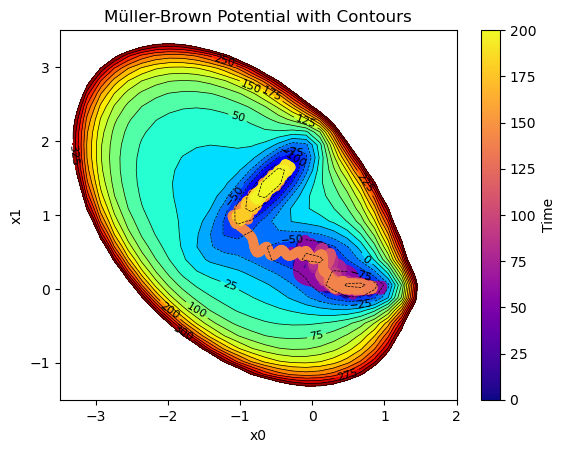

In [7]:
# Plotting trajectory over potential landscape

# set levels for plotting
countour_levels = np.arange(-150,350,25)

# Create the filled contour plot
plt.contourf(x0, x1, Z, levels=countour_levels, cmap='jet')
#plt.colorbar(label='Potential Energy')

# Add contour lines
contour_lines = plt.contour(x0, x1, Z, levels=countour_levels, colors='black', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8)

# Add trajectory
x = traj_p[:,0]
y = traj_p[:,1]
time = dt * np.arange(traj_p.shape[0])
scatter = plt.scatter(x, y, c=time, cmap='plasma', marker='o', label='Trajectory')  # Color by time
plt.colorbar(scatter, label='Time')

# Add labels and title
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Müller-Brown Potential with Contours')

# Show the plot
plt.show()

# No Bofill, No Memory

In [8]:
# Parameters
x = jnp.array([0.7,0])
v = jnp.zeros_like(x)
f = get_F(x)
last_h = get_H(x)
fb = get_gad_force(last_h, f)
queue_fb = np.tile(fb, (1, 1))
mass = 1.0
gamma = 1.0
dt = 0.01
n_steps = 20000
kBT = 2.0  # Thermal energy

In [9]:
# prepare storage arrays
traj_p = np.full((n_steps+1, x.shape[0]), np.nan)
traj_v = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fu = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fb = np.full((n_steps+1, x.shape[0]), np.nan)

traj_p[0,:] = x
traj_v[0,:] = v
traj_fu[0,:] = f
traj_fb[0,:] = fb

In [10]:
# Run the integrator
for i in tqdm(range(1,n_steps+1)):

  x, v, f, fb = baoab_langevin_integrator(
    x, v, f, fb, mass, gamma, dt, kBT, get_F, muller_brown_gad_force_base, i
  )

  traj_p[i,:] = x
  traj_v[i,:] = v
  traj_fu[i,:] = f
  traj_fb[i,:] = fb

# Convert trajectory to numpy array for analysis
traj_p = np.array(traj_p)
traj_v = np.array(traj_v)
traj_fu = np.array(traj_fu)
traj_fb = np.array(traj_fb)

  0%|          | 0/20000 [00:00<?, ?it/s]

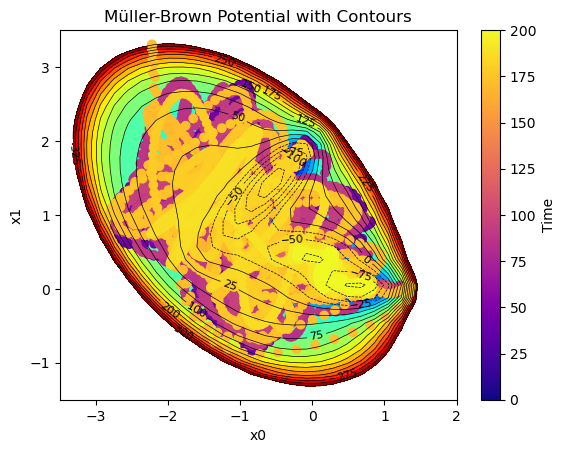

In [11]:
# Plotting trajectory over potential landscape

# set levels for plotting
countour_levels = np.arange(-150,350,25)

# Create the filled contour plot
plt.contourf(x0, x1, Z, levels=countour_levels, cmap='jet')
#plt.colorbar(label='Potential Energy')

# Add contour lines
contour_lines = plt.contour(x0, x1, Z, levels=countour_levels, colors='black', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8)

# Add trajectory
x = traj_p[:,0]
y = traj_p[:,1]
time = dt * np.arange(traj_p.shape[0])
scatter = plt.scatter(x, y, c=time, cmap='plasma', marker='o', label='Trajectory')  # Color by time
plt.colorbar(scatter, label='Time')

# Add labels and title
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Müller-Brown Potential with Contours')

# Show the plot
plt.show()

# Bofill, Memory

In [12]:
# Parameters
x = jnp.array([0.7,0])
v = jnp.zeros_like(x)
f = get_F(x)
last_h = get_H(x)
fb = get_gad_force(last_h, f)
queue_fb = np.tile(fb, (10, 1))
mass = 1.0
gamma = 1.0
dt = 0.01
n_steps = 20000
kBT = 2.0  # Thermal energy

In [13]:
# prepare storage arrays
traj_p = np.full((n_steps+1, x.shape[0]), np.nan)
traj_v = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fu = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fb = np.full((n_steps+1, x.shape[0]), np.nan)

traj_p[0,:] = x
traj_v[0,:] = v
traj_fu[0,:] = f
traj_fb[0,:] = fb

In [14]:
# Run the integrator
for i in tqdm(range(1,n_steps+1)):

  x, v, f, fb = baoab_langevin_integrator(
    x, v, f, fb, mass, gamma, dt, kBT, get_F, muller_brown_gad_force_bofill, i, True)

  traj_p[i,:] = x
  traj_v[i,:] = v
  traj_fu[i,:] = f
  traj_fb[i,:] = fb

# Convert trajectory to numpy array for analysis
traj_p = np.array(traj_p)
traj_v = np.array(traj_v)
traj_fu = np.array(traj_fu)
traj_fb = np.array(traj_fb)

  0%|          | 0/20000 [00:00<?, ?it/s]

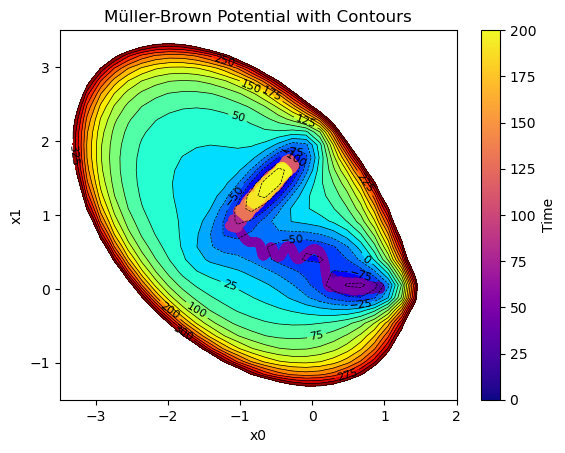

In [15]:
# Plotting trajectory over potential landscape

# set levels for plotting
countour_levels = np.arange(-150,350,25)

# Create the filled contour plot
plt.contourf(x0, x1, Z, levels=countour_levels, cmap='jet')
#plt.colorbar(label='Potential Energy')

# Add contour lines
contour_lines = plt.contour(x0, x1, Z, levels=countour_levels, colors='black', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8)

# Add trajectory
x = traj_p[:,0]
y = traj_p[:,1]
time = dt * np.arange(traj_p.shape[0])
scatter = plt.scatter(x, y, c=time, cmap='plasma', marker='o', label='Trajectory')  # Color by time
plt.colorbar(scatter, label='Time')

# Add labels and title
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Müller-Brown Potential with Contours')

# Show the plot
plt.show()

# Bofill, No Memory

In [16]:
# Parameters
x = jnp.array([0.7,0])
v = jnp.zeros_like(x)
f = get_F(x)
last_h = get_H(x)
fb = get_gad_force(last_h, f)
queue_fb = np.tile(fb, (1, 1))
mass = 1.0
gamma = 1.0
dt = 0.01
n_steps = 20000
kBT = 2.0  # Thermal energy

In [17]:
# prepare storage arrays
traj_p = np.full((n_steps+1, x.shape[0]), np.nan)
traj_v = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fu = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fb = np.full((n_steps+1, x.shape[0]), np.nan)

traj_p[0,:] = x
traj_v[0,:] = v
traj_fu[0,:] = f
traj_fb[0,:] = fb

In [18]:
# Run the integrator
for i in tqdm(range(1,n_steps+1)):

  x, v, f, fb = baoab_langevin_integrator(
    x, v, f, fb, mass, gamma, dt, kBT, get_F, muller_brown_gad_force_bofill, i, True)

  traj_p[i,:] = x
  traj_v[i,:] = v
  traj_fu[i,:] = f
  traj_fb[i,:] = fb

# Convert trajectory to numpy array for analysis
traj_p = np.array(traj_p)
traj_v = np.array(traj_v)
traj_fu = np.array(traj_fu)
traj_fb = np.array(traj_fb)

  0%|          | 0/20000 [00:00<?, ?it/s]

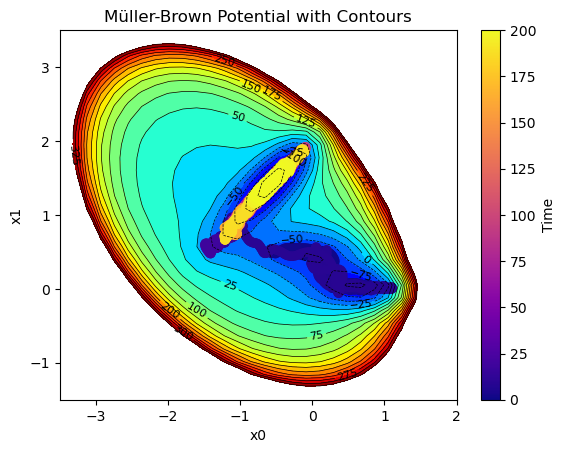

In [19]:
# Plotting trajectory over potential landscape

# set levels for plotting
countour_levels = np.arange(-150,350,25)

# Create the filled contour plot
plt.contourf(x0, x1, Z, levels=countour_levels, cmap='jet')
#plt.colorbar(label='Potential Energy')

# Add contour lines
contour_lines = plt.contour(x0, x1, Z, levels=countour_levels, colors='black', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8)

# Add trajectory
x = traj_p[:,0]
y = traj_p[:,1]
time = dt * np.arange(traj_p.shape[0])
scatter = plt.scatter(x, y, c=time, cmap='plasma', marker='o', label='Trajectory')  # Color by time
plt.colorbar(scatter, label='Time')

# Add labels and title
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Müller-Brown Potential with Contours')

# Show the plot
plt.show()

# No Bofill, No Memory (Deep well)

In [20]:
# Parameters
x = jnp.array([-0.5, 1.5])
v = jnp.zeros_like(x)
f = get_F(x)
last_h = get_H(x)
fb = get_gad_force(last_h, f)
queue_fb = np.tile(fb, (1, 1))
mass = 1.0
gamma = 1.0
dt = 0.01
n_steps = 50000
kBT = 2.0  # Thermal energy

In [21]:
# prepare storage arrays
traj_p = np.full((n_steps+1, x.shape[0]), np.nan)
traj_v = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fu = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fb = np.full((n_steps+1, x.shape[0]), np.nan)

traj_p[0,:] = x
traj_v[0,:] = v
traj_fu[0,:] = f
traj_fb[0,:] = fb

In [22]:
# Run the integrator
for i in tqdm(range(1,n_steps+1)):

  x, v, f, fb = baoab_langevin_integrator(
    x, v, f, fb, mass, gamma, dt, kBT, get_F, muller_brown_gad_force_base, i
  )

  traj_p[i,:] = x
  traj_v[i,:] = v
  traj_fu[i,:] = f
  traj_fb[i,:] = fb

# Convert trajectory to numpy array for analysis
traj_p = np.array(traj_p)
traj_v = np.array(traj_v)
traj_fu = np.array(traj_fu)
traj_fb = np.array(traj_fb)

  0%|          | 0/50000 [00:00<?, ?it/s]

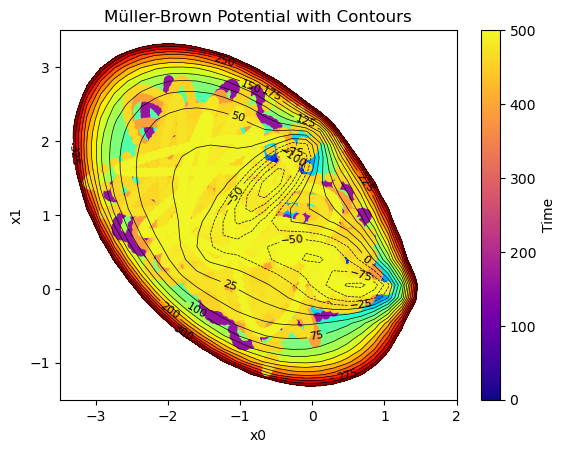

In [23]:
# Plotting trajectory over potential landscape

# set levels for plotting
countour_levels = np.arange(-150,350,25)

# Create the filled contour plot
plt.contourf(x0, x1, Z, levels=countour_levels, cmap='jet')
#plt.colorbar(label='Potential Energy')

# Add contour lines
contour_lines = plt.contour(x0, x1, Z, levels=countour_levels, colors='black', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8)

# Add trajectory
x = traj_p[:,0]
y = traj_p[:,1]
time = dt * np.arange(traj_p.shape[0])
scatter = plt.scatter(x, y, c=time, cmap='plasma', marker='o', label='Trajectory')  # Color by time
plt.colorbar(scatter, label='Time')

# Add labels and title
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Müller-Brown Potential with Contours')

# Show the plot
plt.show()

# Bofill, No Memory (Deep well)

In [24]:
# Parameters
x = jnp.array([-0.5, 1.5])
v = jnp.zeros_like(x)
f = get_F(x)
last_h = get_H(x)
fb = get_gad_force(last_h, f)
queue_fb = np.tile(fb, (1, 1))
mass = 1.0
gamma = 1.0
dt = 0.01
n_steps = 50000
kBT = 2.0  # Thermal energy

In [25]:
# prepare storage arrays
traj_p = np.full((n_steps+1, x.shape[0]), np.nan)
traj_v = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fu = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fb = np.full((n_steps+1, x.shape[0]), np.nan)

traj_p[0,:] = x
traj_v[0,:] = v
traj_fu[0,:] = f
traj_fb[0,:] = fb

In [26]:
# Run the integrator
for i in tqdm(range(1,n_steps+1)):

  x, v, f, fb = baoab_langevin_integrator(
    x, v, f, fb, mass, gamma, dt, kBT, get_F, muller_brown_gad_force_bofill, i, True)

  traj_p[i,:] = x
  traj_v[i,:] = v
  traj_fu[i,:] = f
  traj_fb[i,:] = fb

# Convert trajectory to numpy array for analysis
traj_p = np.array(traj_p)
traj_v = np.array(traj_v)
traj_fu = np.array(traj_fu)
traj_fb = np.array(traj_fb)

  0%|          | 0/50000 [00:00<?, ?it/s]

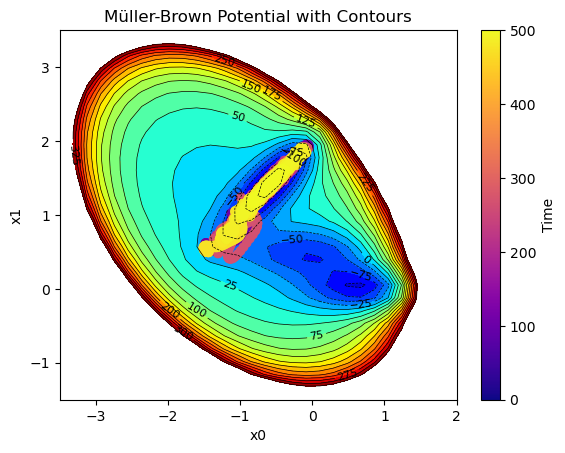

In [27]:
# Plotting trajectory over potential landscape

# set levels for plotting
countour_levels = np.arange(-150,350,25)

# Create the filled contour plot
plt.contourf(x0, x1, Z, levels=countour_levels, cmap='jet')
#plt.colorbar(label='Potential Energy')

# Add contour lines
contour_lines = plt.contour(x0, x1, Z, levels=countour_levels, colors='black', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8)

# Add trajectory
x = traj_p[:,0]
y = traj_p[:,1]
time = dt * np.arange(traj_p.shape[0])
scatter = plt.scatter(x, y, c=time, cmap='plasma', marker='o', label='Trajectory')  # Color by time
plt.colorbar(scatter, label='Time')

# Add labels and title
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Müller-Brown Potential with Contours')

# Show the plot
plt.show()

# No Bofill, Memory (Deep well)

In [28]:
# Parameters
x = jnp.array([-0.5, 1.5])
v = jnp.zeros_like(x)
f = get_F(x)
last_h = get_H(x)
fb = get_gad_force(last_h, f)
queue_fb = np.tile(fb, (10, 1))
mass = 1.0
gamma = 1.0
dt = 0.01
n_steps = 50000
kBT = 2.0  # Thermal energy

In [29]:
# prepare storage arrays
traj_p = np.full((n_steps+1, x.shape[0]), np.nan)
traj_v = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fu = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fb = np.full((n_steps+1, x.shape[0]), np.nan)

traj_p[0,:] = x
traj_v[0,:] = v
traj_fu[0,:] = f
traj_fb[0,:] = fb

In [30]:
# Run the integrator
for i in tqdm(range(1,n_steps+1)):

  x, v, f, fb = baoab_langevin_integrator(
    x, v, f, fb, mass, gamma, dt, kBT, get_F, muller_brown_gad_force_base, i
  )

  traj_p[i,:] = x
  traj_v[i,:] = v
  traj_fu[i,:] = f
  traj_fb[i,:] = fb

# Convert trajectory to numpy array for analysis
traj_p = np.array(traj_p)
traj_v = np.array(traj_v)
traj_fu = np.array(traj_fu)
traj_fb = np.array(traj_fb)

  0%|          | 0/50000 [00:00<?, ?it/s]

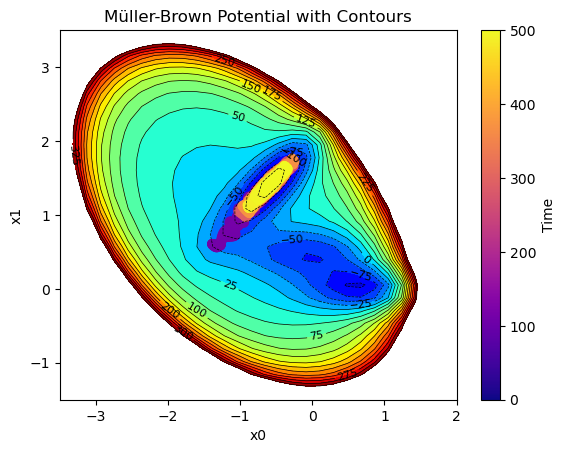

In [31]:
# Plotting trajectory over potential landscape

# set levels for plotting
countour_levels = np.arange(-150,350,25)

# Create the filled contour plot
plt.contourf(x0, x1, Z, levels=countour_levels, cmap='jet')
#plt.colorbar(label='Potential Energy')

# Add contour lines
contour_lines = plt.contour(x0, x1, Z, levels=countour_levels, colors='black', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8)

# Add trajectory
x = traj_p[:,0]
y = traj_p[:,1]
time = dt * np.arange(traj_p.shape[0])
scatter = plt.scatter(x, y, c=time, cmap='plasma', marker='o', label='Trajectory')  # Color by time
plt.colorbar(scatter, label='Time')

# Add labels and title
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Müller-Brown Potential with Contours')

# Show the plot
plt.show()

# Bofill, Memory (Deep well)

In [32]:
# Parameters
x = jnp.array([-0.5, 1.5])
v = jnp.zeros_like(x)
f = get_F(x)
last_h = get_H(x)
fb = get_gad_force(last_h, f)
queue_fb = np.tile(fb, (10, 1))
mass = 1.0
gamma = 1.0
dt = 0.01
n_steps = 50000
kBT = 2.0  # Thermal energy

In [33]:
# prepare storage arrays
traj_p = np.full((n_steps+1, x.shape[0]), np.nan)
traj_v = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fu = np.full((n_steps+1, x.shape[0]), np.nan)
traj_fb = np.full((n_steps+1, x.shape[0]), np.nan)

traj_p[0,:] = x
traj_v[0,:] = v
traj_fu[0,:] = f
traj_fb[0,:] = fb

In [34]:
# Run the integrator
for i in tqdm(range(1,n_steps+1)):

  x, v, f, fb = baoab_langevin_integrator(
    x, v, f, fb, mass, gamma, dt, kBT, get_F, muller_brown_gad_force_bofill, i, True)

  traj_p[i,:] = x
  traj_v[i,:] = v
  traj_fu[i,:] = f
  traj_fb[i,:] = fb

# Convert trajectory to numpy array for analysis
traj_p = np.array(traj_p)
traj_v = np.array(traj_v)
traj_fu = np.array(traj_fu)
traj_fb = np.array(traj_fb)

  0%|          | 0/50000 [00:00<?, ?it/s]

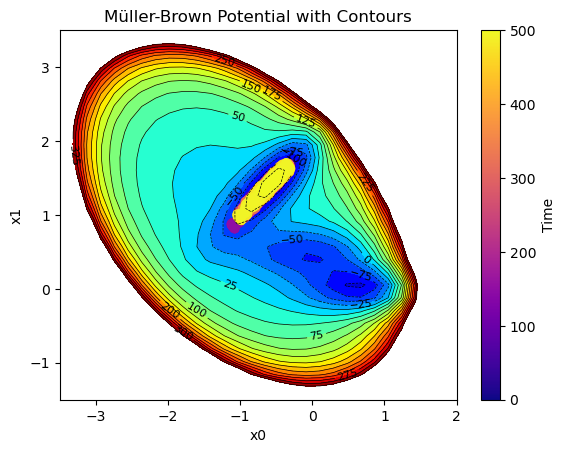

In [35]:
# Plotting trajectory over potential landscape

# set levels for plotting
countour_levels = np.arange(-150,350,25)

# Create the filled contour plot
plt.contourf(x0, x1, Z, levels=countour_levels, cmap='jet')
#plt.colorbar(label='Potential Energy')

# Add contour lines
contour_lines = plt.contour(x0, x1, Z, levels=countour_levels, colors='black', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8)

# Add trajectory
x = traj_p[:,0]
y = traj_p[:,1]
time = dt * np.arange(traj_p.shape[0])
scatter = plt.scatter(x, y, c=time, cmap='plasma', marker='o', label='Trajectory')  # Color by time
plt.colorbar(scatter, label='Time')

# Add labels and title
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Müller-Brown Potential with Contours')

# Show the plot
plt.show()

Evidently, the length of the memory we keep of the past bias forces "smoothens" the resulting bias, causing it to be too weak to get out of deep wells.
It can also lead to the average pushing in the wrong direction around the corners if the hill to climb is not steep, but has a long slope.